In [3]:
%matplotlib inline
#
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from lrg_eegfc import *
#
path_data_ = Path('data')
path_data = path_data_ / 'stereoeeg_patients'
path_figs = Path('data') / 'figures' / 'test'
path_figs.mkdir(parents=True, exist_ok=True)

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


### Data Reader

In [4]:
data_dict = load_dataset(path_data, ['Pat_02', 'Pat_08'])

In [5]:
data_dict['Pat_02']

{'rsPre': PatientRecording(timeseries=array([[-13.31505268,  -9.56112223,  -6.73066148, ...,   7.8814298 ,
           7.54071147,   6.91933594],
        [-18.29872891, -16.82323932, -15.88530869, ...,  10.19933632,
           9.51864352,   8.56682976],
        [-23.84604025, -27.18449335, -29.82154799, ...,  -4.18745436,
          -3.87387472,  -3.74154854],
        ...,
        [-33.80101962, -30.41774716, -27.49405978, ..., -11.97684623,
         -11.83201294, -11.80967329],
        [-39.00814942, -36.24516817, -33.83168667, ..., -12.3381679 ,
         -12.03825676, -11.76011977],
        [-14.09218899, -10.53318807,  -7.62021607, ..., -21.5027313 ,
         -20.46259743, -19.20631841]]), parameters={'fs': 2048.0, 'fcutHigh': 300.0, 'fcutLow': 0.53, 'filter_order': 4.0}, channel_metadata=None),
 'taskLearn': PatientRecording(timeseries=array([[ 25.12002837,  29.39795112,  32.70690531, ...,  -9.55669841,
          -8.88644864,  -8.23448655],
        [ 11.38775729,  14.47611463,  16.76

In [4]:
dat = data_dict['Pat_02']['rsPost'].timeseries

In [5]:
adj = np.corrcoef(dat)
np.fill_diagonal(adj, 0)
adj[adj < 0] = 0

Text(0.5, 0, '$\\theta$')

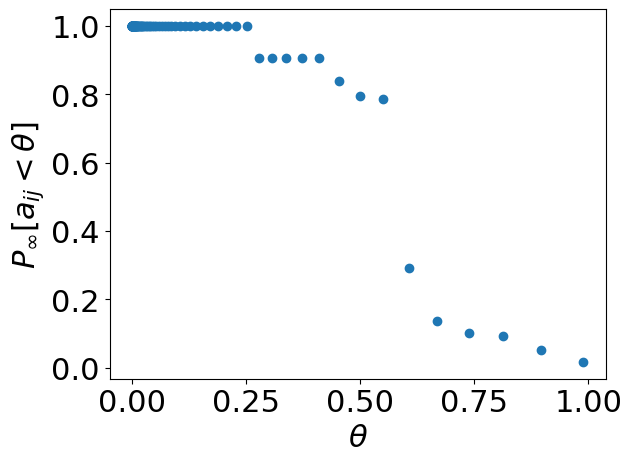

In [6]:
G = nx.from_numpy_array(adj)
Th, Pinf, Einf = compute_threshold_stats_fast(G)

plt.rcParams.update({'font.size': 22})
plt.plot(Th, Einf, 'o')
plt.ylabel(r'$P_\infty[a_{ij} < \theta]$')
plt.xlabel(r'$\theta$')

In [7]:
# Generate connected ER network adjacency matrix with random positive weights
def generate_connected_er_graph(n_nodes, p):
    """
    Generate a connected Erdős-Rényi graph with random positive weights.
    """
    # Generate ER graph
    G = nx.erdos_renyi_graph(n_nodes, p)
    while not nx.is_connected(G):
        G = nx.erdos_renyi_graph(n_nodes, p)
    # Assign random weights
    for (u, v) in G.edges():
        G[u][v]['weight'] = np.random.uniform(0.1, 1.0)
    return G
G_er = generate_connected_er_graph(n_nodes=1000, p=0.05)
adj_er = nx.to_numpy_array(G_er)

In [18]:
# Generate 2D lattice adjacency matrix
n_side = 32  # Use square root of existing n_nodes for lattice dimension
adj_lattice = np.zeros((n_side**2, n_side**2))

# Connect each node to its 4 neighbors (up, down, left, right) with uniform weight

for i in range(n_side):
    for j in range(n_side):
        weight = np.random.uniform(0.1, 1.0)
        node = i * n_side + j
        
        # Right neighbor
        if j < n_side - 1:
            neighbor = i * n_side + (j + 1)
            adj_lattice[node, neighbor] = weight
            adj_lattice[neighbor, node] = weight
        
        # Down neighbor  
        if i < n_side - 1:
            neighbor = (i + 1) * n_side + j
            adj_lattice[node, neighbor] = weight
            adj_lattice[neighbor, node] = weight

print(f"Generated {n_side}x{n_side} lattice adjacency matrix: {adj_lattice.shape}")
print(f"Number of edges: {np.sum(adj_lattice > 0) // 2}")

Generated 32x32 lattice adjacency matrix: (1024, 1024)
Number of edges: 1984


In [28]:
# Generate scale-free Barabási-Albert network adjacency matrix with uniform random weights
def generate_barabasi_albert_graph(n_nodes, m):
    """
    Generate a Barabási-Albert scale-free graph with random positive weights.
    
    Parameters:
    n_nodes: number of nodes
    m: number of edges to attach from a new node to existing nodes
    """
    G = nx.barabasi_albert_graph(n_nodes, m)
    
    # Assign random weights to all edges
    for (u, v) in G.edges():
        G[u][v]['weight'] = np.random.uniform(0.1, 1.0)
    
    return G
G_ba = generate_barabasi_albert_graph(n_nodes=2000, m=1)



In [29]:
def update_barabasi_albert_weights(G):
    """
    Update the weights of an existing Barabási-Albert graph with new random values.
    
    Parameters:
    G: NetworkX graph object (Barabási-Albert graph with existing weights)
    
    Returns:
    G: The same graph with updated random weights
    """
    for (u, v) in G.edges():
        G[u][v]['weight'] = np.random.uniform(0.1, 1.0)
    
    return G

# Generate the scale-free network
G_ba = update_barabasi_albert_weights(G_ba)
adj_ba = nx.to_numpy_array(G_ba)

In [30]:
# Create fully connected adjacency matrix with uniform random weights in [0,1]
adj_fully_connected = np.random.uniform(0, 1, (100, 100))

# Make it symmetric (undirected graph)
adj_fully_connected = (adj_fully_connected + adj_fully_connected.T) / 2

# Set diagonal to 0 (no self-loops)
np.fill_diagonal(adj_fully_connected, 0)

print(f"Generated fully connected adjacency matrix: {adj_fully_connected.shape}")
print(f"Number of edges: {np.sum(adj_fully_connected > 0) // 2}")

Generated fully connected adjacency matrix: (100, 100)
Number of edges: 4950


In [31]:
list_of_thresholds = np.linspace(0, 0.7, 7)
list_of_max_cc_graphs = []
adj_graph = adj_ba.copy()
for th in list_of_thresholds:
    adj_th = np.where(adj_graph > th, adj_graph, 0)
    G = nx.from_numpy_array(adj_th)
    GCC = max(nx.connected_components(G), key=len)
    G_sub = G.subgraph(GCC).copy()
    list_of_max_cc_graphs.append(G_sub)

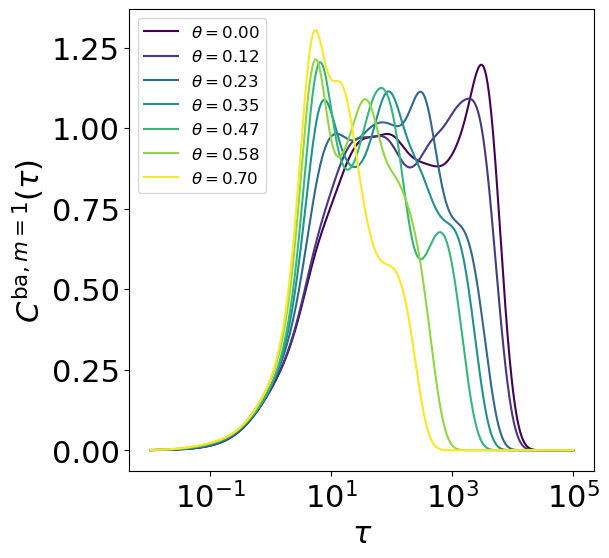

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
#
colors = plt.cm.viridis(np.linspace(0, 1, len(list_of_max_cc_graphs)))
#
for i, G in enumerate(list_of_max_cc_graphs):
    Sm1, Csp, VarL, tt = entropy(G)
    ax.plot(tt[1:], Csp, color=colors[i], label=rf'$\theta={list_of_thresholds[i]:.2f}$')
#
ax.set_xscale('log')
ax.set_xlabel(r'$\tau$')
# ax.set_ylabel(r'$C^{\text{ba},m=1}(\tau)$')
ax.set_ylabel(r'$C^{\text{ba},m=1}(\tau)$')
ax.legend(fontsize=12)

In [ ]:
th = 0.5
adj_th = np.where(adj > th, adj, 0)


In [102]:
G = nx.from_numpy_array(adj_th)
list(nx.connected_components(G))[0].__len__()

93

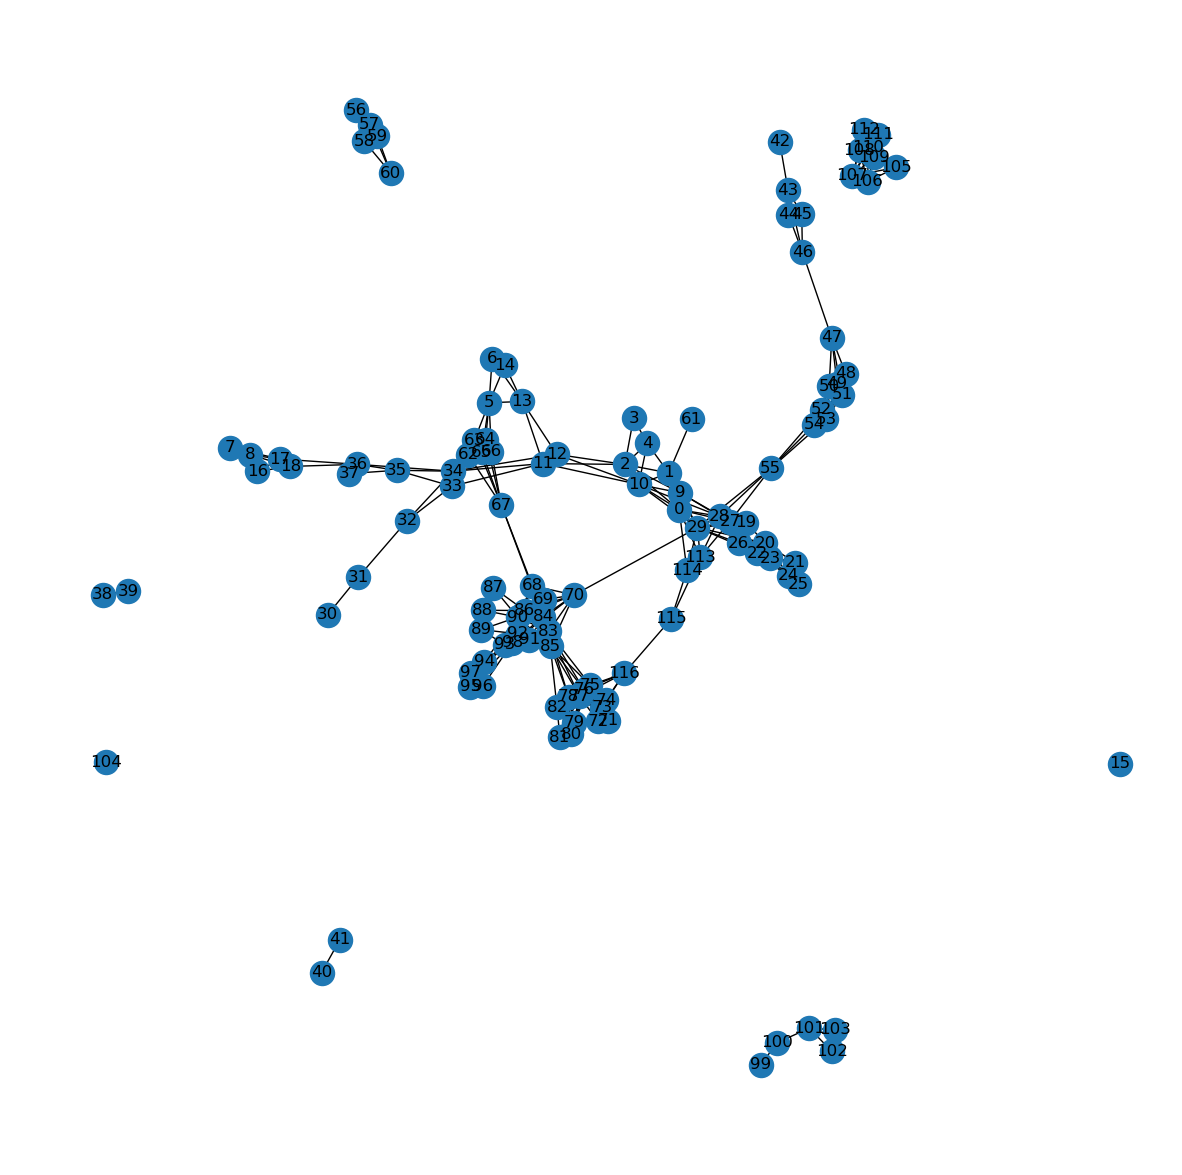

In [103]:
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(G, with_labels=True)

In [104]:
GCC = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(GCC).copy()

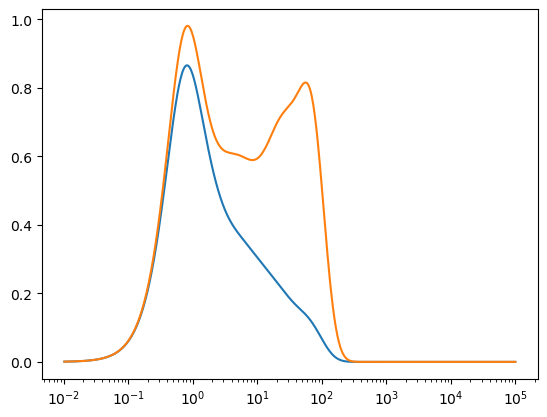

In [105]:
Sm1, Csp, VarL, tt = entropy(G)
Sm1_sub, Csp_sub, VarL_sub, tt_sub = entropy(G_sub)
plt.plot(tt[1:], Csp,)
plt.plot(tt_sub[1:], Csp_sub)

plt.xscale('log')